# <span style='color:red'>Quantitative Investing with Python</span>

### Professor Juhani Linnainmaa

Dartmouth College and Kepos Capital

*Last revised:* January 20, 2025

--- 

# **Topic 4:** Replicating Academic Factors and Measuring Alphas

1. We will merge accounting data from Compustat and stock data from CRSP
   - I'll use the processed CRSP file we created and saved previously
   - By having the merged dataset, we can construct factors such as HML, which is based on sorting stocks into portfolios by their book-to-market ratios<br><br>


2. I provide some general code for constructing factors based on arbitrary signals, such as BE/ME or the signal underneath the momentum factor 
   - I'll be more careful in my replicating than what I did with the short-term reversals factor
   - There are some more details. These are not *that* important in practice, but it is useful to think about them---at the very least, we highlight the fact that many decisions go into constructing trading strategies / factors<br><br>


3. We will then estimate linear regression to assess strategies'/factors' alphas in asset pricing models such as the Capital Asset Pricing model or the Fama-French five-factor model
   - I'll use the same Fama-French factors we downloaded and pickled previously
   - I'll discuss the meaning of alphas in class, not on this notebook

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import requests
from io import BytesIO, StringIO
import zipfile

<br>
<div style="text-align: center; font-family: 'Georgia', sans-serif; font-size: 36px; font-weight: bold; color: red;">
    Read and process annual fundamentals from Compustat
</div>

- Compustat is a well-known provider of fundamental data
  - Fundamental in this context means accounting data, that is, income statement and balance sheet information
- I downloaded all data for U.S. firms. I look at *annual* reports, which is still the standard in academic literature
  - The same ideas of course apply if we use quarterly data or any other data sources (such as CapitalIQ or Datastream) besides Compustat

In [2]:
compustat_url = 'https://dl.dropboxusercontent.com/scl/fi/vd2ci1fw093kbx9375m2z/Compustat_September2023.csv.zip?rlkey=g68xz4deyiq5n7cx5n7q1ma0u'
response = requests.get(compustat_url)
with zipfile.ZipFile(BytesIO(response.content)) as z:
    with z.open('Compustat_September2023.csv') as f:
        df = pd.read_csv(f)

df.tail(3)

,GVKEY,LPERMNO,datadate,fyear,tic,conm,at,ceq,cogs,lt,pstk,pstkl,pstkrv,sale,seq,txditc,xrd,xsga
326679,351038,16161,2021-12-31,2021.0,QNRX,QUOIN PHARMACEUTICALS LTD,9.357,0.657,0.000,8.700,0.0,0.0,0.0,0.000,0.657,0.000,1.563,5.959
326680,351038,16161,2022-12-31,2022.0,QNRX,QUOIN PHARMACEUTICALS LTD,14.458,7.407,0.000,7.051,0.0,0.0,0.0,0.000,7.407,0.000,2.673,9.153
326681,353444,23209,2022-12-31,2022.0,HLN,HALEON PLC,41948.594,19677.222,4629.226,22119.555,0.0,0.0,0.0,13082.804,19677.222,4338.845,361.470,5194.324


## Pre-process the data a bit

1. Rename the stock identifier variable to be consistent with the CRSP name
2. Compute the book value of equity using the Fama-French definition
   - Fama and French (1993) don't provide all the details
   - Cohen, Polk, and Vuolteenaho (2003), who were Ph.D. students at Chicago, write:
   
     > Book equity is defined as the stockholders' equity, plus balance sheet deferred taxes (data item 74) and investment tax credit (data item 208; if available), plus postretirement benefit liabilities (data item 330; if available), minus the book value of preferred stock. Depending on availability, we use redemption (data item 56), liquidation (data item 10), or par value (data item 130) in that order for the book value of preferred stock. Stockholders' equity used in the above formula is calculated as follows. We prefer the stockholders' equity number reported by Moody's or COMPUSTAT (data item 216). If neither one is available, we measure stockholders' equity as the book value of common equity (data item 60), plus the par value of preferred stock. (Note that the preferred stock is added at this stage, because it is later subtracted in the book equity formula.) If common equity is not available, we compute stockholders' equity as the book value of assets (data item 6) minus total liabilities (data item 181), all from COMPUSTAT.
   

In [3]:
# rename stock identifier to be consistent with CRSP
df = df.rename(columns = {'LPERMNO': 'permno'})
df['datadate'] = pd.to_datetime(df['datadate'], format='%Y-%m-%d').dt.to_period('M').dt.to_timestamp()
df = df.set_index(['permno', 'datadate'])

# compute book value of equity using the Fama-French rules
be = df['seq'].combine_first(df['ceq'] + df['pstk']).combine_first(df['at'] - df['lt'])

# 1. compute preferred stock
pref = df['pstkrv'].combine_first(df['pstkl']).combine_first(df['pstk'])

# 2. adjust book value of equity for preferred stock (if exists)
pref_not_missing = pref.notnull()
be.loc[pref_not_missing] -= pref

# 3. investment tax credit (only for fiscal years ending in 1993 or before)
df['txditc'] = df['txditc'].replace({np.nan: 0})
before_1993 = df.index.get_level_values('datadate') <= '1993-12'
be.loc[before_1993] += df.loc[before_1993, 'txditc']

df['be'] = be

df.tail(5)

GVKEY   fyear   tic                       conm         at  \
permno datadate                                                                 
15642  2022-12-01  349972  2022.0  INDP  INDAPTUS THERAPEUTICS INC     28.064   
22205  2021-12-01  350681  2021.0   GET       GETNET ADQUIRENCIA E  10595.813   
16161  2021-12-01  351038  2021.0  QNRX  QUOIN PHARMACEUTICALS LTD      9.357   
       2022-12-01  351038  2022.0  QNRX  QUOIN PHARMACEUTICALS LTD     14.458   
23209  2022-12-01  353444  2022.0   HLN                 HALEON PLC  41948.594   

                         ceq      cogs         lt  pstk  pstkl  pstkrv  \
permno datadate                                                          
15642  2022-12-01     24.631     0.000      3.433   0.0    0.0     0.0   
22205  2021-12-01    595.890   265.517   9999.222   0.0    0.0     0.0   
16161  2021-12-01      0.657     0.000      8.700   0.0    0.0     0.0   
       2022-12-01      7.407     0.000      7.051   0.0    0.0     0.0   
23209  2022-12-01  19677.222  4629.226  22119.555   0.0    0.0     0.0   

                        sale        seq    txditc      xrd      xsga  \
permno datadate                                                        
15642  2022-12-01      0.000     24.631     0.000    6.325    14.909   
22205  2021-12-01    512.094    595.890     0.600      NaN    65.598   
16161  2021-12-01      0.000      0.657     0.000    1.563     5.959   
       2022-12-01      0.000      7.407     0.000    2.673     9.153   
23209  2022-12-01  13082.804  19677.222  4338.845  361.470  5194.324   

                          be  
permno datadate               
15642  2022-12-01     24.631  
22205  2021-12-01    595.890  
16161  2021-12-01      0.657  
       2022-12-01      7.407  
23209  2022-12-01  19677.222

## Keep only the necessary data

- PERMNO and datadate (which are in the index)
- at (total assets)
- sale (revenue) and cogs (cost of goods sold)
- be (book value of equity)
- **Note:** I don't use at, sale, and cogs on this notebook, but I'll leave them in for reasons to be discussed in class

In [4]:
cs_vars = ['at', 'sale', 'cogs', 'be']

compustat = df[['at', 'sale', 'cogs', 'be']].copy().dropna(how='all')
compustat.head(10)

at    sale    cogs      be
permno datadate                                  
25881  1970-12-01  33.450  45.335  30.529  10.544
       1971-12-01  29.330  47.033  33.973   8.382
       1972-12-01  19.907  34.362  22.702   7.309
       1973-12-01  21.771  37.750  24.704   8.798
       1974-12-01  25.638  50.325  36.646   8.279
       1975-12-01  23.905  51.192  35.237  11.020
       1976-12-01  38.586  66.414  45.277  15.527
       1977-12-01  44.025  77.946  56.959  17.673
10015  1983-12-01  14.080  25.395   6.310   7.823
       1984-12-01  16.267  32.007   8.171   9.319

### Load CRSP data from Topic #3 and filter Compustat data so that it only includes the PERMNOs we have in the CRSP data

In [5]:
cs_crsp = pd.read_pickle('/home/jovyan/data/crsp.pkl')
cs_crsp = cs_crsp.reset_index(level='date')
cs_crsp = cs_crsp.set_index('date', append=True)
display(cs_crsp.tail(5))

ok = compustat.index.get_level_values('permno').isin(cs_crsp.index.get_level_values('permno').unique())
print(f'Compustat shape before filtering: {compustat.shape}')
compustat = compustat[ok]
print(f'Compustat shape after filtering: {compustat.shape}')

exchcd       ret          me
permno date                                    
93426  2022-11-01     1.0  0.202074  509.194066
       2022-12-01     1.0 -0.047326  485.096169
       2023-01-01     1.0  0.117206  541.952184
       2023-02-01     1.0  0.009727  547.223581
       2023-03-01     1.0 -0.042202  524.296779

Compustat shape before filtering: (305122, 4)
Compustat shape after filtering: (65480, 4)


<br>
<div style="text-align: center; font-family: 'Georgia', sans-serif; font-size: 36px; font-weight: bold; color: red;">
    Merge Compustat data with CRSP
</div>

- We have monthly stocks returns but *annual* Compustat data
- Moreover, Compustat data is reported *not* when the information is available to investors but by fiscal-year ends
  - Variable ```datadate``` tells the end date of the fiscal year
- **THIS IS A PROBLEM!**
  - I need to lag Compustat data appropriately relative to CRSP
  - What does this mean? 
    - Companies announce their earnings with some lag 
    - A conservative assumption from Fama-French is that accounting data from a fiscal year that ended in year t is available at the end of June in year t+1
  - We could do this in many different ways but I use the following logic:
    1. Reindex Compustat data so that we have data for all months over which the same stock is present in either CRSP or Compustat
    2. Lag fundamental information by six months (the Fama-French assumption)
    3. Forward fill the data for up to 23 months
- We now have monthly observations that we can merge directly with CRSP

In [6]:
# rename Compustat datadate variable to 'date'
compustat = compustat.rename_axis(index={'datadate': 'date'})

# reindex Compustat data to cover all dates seen in Compustat and CRSP 
cs_index = compustat.index
crsp_index = cs_crsp.index
combined_index = cs_index.union(crsp_index)
compustat = compustat.reindex(combined_index)

# there might be some gaps in dates
# in the code below, I create an index that covers every month from the first time we see a firm to the last time
min_max_dates = compustat.reset_index(level='date').groupby(level='permno').agg(min_date=('date', 'min'), max_date=('date', 'max'))

# Create list for multi-index to cover all months for each firm
multi_index_list = []

for index, row in min_max_dates.iterrows():
    months_range = pd.date_range(start=row['min_date'], end=row['max_date'], freq='MS')
    for month in months_range:
        multi_index_list.append((index, month))

new_index = pd.MultiIndex.from_tuples(multi_index_list, names=['permno', 'date'])
compustat = compustat.reindex(new_index)

print('Data without shifting and ffill')
display(compustat.tail(25))
# we want to lag data by six months (so that if a firm's fiscal year ends in December, we see this info next June)
# we also want to forward-fill data. If we forward fill exactly 11 months we'd cover all months until the next fiscal year end
# however, Compustat data might have gaps, so I forward fill by 23 months (it'll cover one missed annual report)

compustat = compustat.groupby(level='permno').shift(6).ffill(limit=23)
print('Data after shifting and ffill')
display(compustat.tail(25))

Data without shifting and ffill


at     sale     cogs       be
permno date                                          
93426  2021-03-01      NaN      NaN      NaN      NaN
       2021-04-01      NaN      NaN      NaN      NaN
       2021-05-01      NaN      NaN      NaN      NaN
       2021-06-01      NaN      NaN      NaN      NaN
       2021-07-01      NaN      NaN      NaN      NaN
       2021-08-01      NaN      NaN      NaN      NaN
       2021-09-01      NaN      NaN      NaN      NaN
       2021-10-01      NaN      NaN      NaN      NaN
       2021-11-01      NaN      NaN      NaN      NaN
       2021-12-01  461.889  317.919  171.898  277.099
       2022-01-01      NaN      NaN      NaN      NaN
       2022-02-01      NaN      NaN      NaN      NaN
       2022-03-01      NaN      NaN      NaN      NaN
       2022-04-01      NaN      NaN      NaN      NaN
       2022-05-01      NaN      NaN      NaN      NaN
       2022-06-01      NaN      NaN      NaN      NaN
       2022-07-01      NaN      NaN      NaN      NaN
       2022-08-01      NaN      NaN      NaN      NaN
       2022-09-01      NaN      NaN      NaN      NaN
       2022-10-01      NaN      NaN      NaN      NaN
       2022-11-01      NaN      NaN      NaN      NaN
       2022-12-01  476.742  362.580  195.937  306.547
       2023-01-01      NaN      NaN      NaN      NaN
       2023-02-01      NaN      NaN      NaN      NaN
       2023-03-01      NaN      NaN      NaN      NaN

Data after shifting and ffill


at     sale     cogs       be
permno date                                          
93426  2021-03-01  370.413  283.958  159.292  241.360
       2021-04-01  370.413  283.958  159.292  241.360
       2021-05-01  370.413  283.958  159.292  241.360
       2021-06-01  401.887  269.812  152.031  257.823
       2021-07-01  401.887  269.812  152.031  257.823
       2021-08-01  401.887  269.812  152.031  257.823
       2021-09-01  401.887  269.812  152.031  257.823
       2021-10-01  401.887  269.812  152.031  257.823
       2021-11-01  401.887  269.812  152.031  257.823
       2021-12-01  401.887  269.812  152.031  257.823
       2022-01-01  401.887  269.812  152.031  257.823
       2022-02-01  401.887  269.812  152.031  257.823
       2022-03-01  401.887  269.812  152.031  257.823
       2022-04-01  401.887  269.812  152.031  257.823
       2022-05-01  401.887  269.812  152.031  257.823
       2022-06-01  461.889  317.919  171.898  277.099
       2022-07-01  461.889  317.919  171.898  277.099
       2022-08-01  461.889  317.919  171.898  277.099
       2022-09-01  461.889  317.919  171.898  277.099
       2022-10-01  461.889  317.919  171.898  277.099
       2022-11-01  461.889  317.919  171.898  277.099
       2022-12-01  461.889  317.919  171.898  277.099
       2023-01-01  461.889  317.919  171.898  277.099
       2023-02-01  461.889  317.919  171.898  277.099
       2023-03-01  461.889  317.919  171.898  277.099

### Merge Compustat data with CRSP and pickle

In [7]:
cs_crsp = cs_crsp.merge(compustat, left_index=True, right_index=True, how='left')
display(cs_crsp.tail(12))

cs_crsp.to_pickle('/home/jovyan/data/cs_crsp.pkl')

exchcd       ret          me       at     sale     cogs  \
permno date                                                                  
93426  2022-04-01     1.0 -0.029238  393.901398  401.887  269.812  152.031   
       2022-05-01     1.0 -0.025953  383.678395  401.887  269.812  152.031   
       2022-06-01     1.0 -0.041776  367.649719  461.889  317.919  171.898   
       2022-07-01     1.0  0.070374  393.522784  461.889  317.919  171.898   
       2022-08-01     1.0  0.100385  433.403937  461.889  317.919  171.898   
       2022-09-01     1.0 -0.137569  373.780882  461.889  317.919  171.898   
       2022-10-01     1.0  0.140588  426.330000  461.889  317.919  171.898   
       2022-11-01     1.0  0.202074  509.194066  461.889  317.919  171.898   
       2022-12-01     1.0 -0.047326  485.096169  461.889  317.919  171.898   
       2023-01-01     1.0  0.117206  541.952184  461.889  317.919  171.898   
       2023-02-01     1.0  0.009727  547.223581  461.889  317.919  171.898   
       2023-03-01     1.0 -0.042202  524.296779  461.889  317.919  171.898   

                        be  
permno date                 
93426  2022-04-01  257.823  
       2022-05-01  257.823  
       2022-06-01  277.099  
       2022-07-01  277.099  
       2022-08-01  277.099  
       2022-09-01  277.099  
       2022-10-01  277.099  
       2022-11-01  277.099  
       2022-12-01  277.099  
       2023-01-01  277.099  
       2023-02-01  277.099  
       2023-03-01  277.099

<br>
<div style="text-align: center; font-family: 'Georgia', sans-serif; font-size: 36px; font-weight: bold; color: red;">
    Define three functions for replicating academic factors and analyzing returns
</div>


## Function 1: Assign stocks into portfolios based on breakpoints

- I let the function take in a bunch of inputs so that we can be flexible to create all kinds of factors
- I define the variable by which I want to sort; a list of breakpoints; what the output variable will be called; and how often stocks are re-sorted into portfolios

Note:

- Fama and French update their portfolio sorts only in June
- If we do similar "annual" sorts:
  - Set non-June assignments to zero
  - Copy previous groups assignment forward to fill non-June months
  
## Function 2: Assign compute portfolio returns for sorts define in 'sort_groups'

- This function computes value-weighted portfolio returns   
- My timing convention is different from Topic 3: I do the computations from the viewpoint of the signal, and so the return I compute is for the **next month**
  - Once I have the factor returns, I shift the dates so that the final returns align with the dates the right way

## Function 3: Analysis function for measuring Sharpe ratios 

- This is from the previous notebook

In [8]:
def portfolio_sort(df=None, col=None, percentiles=None, id_col=None, annual=True):
    sortvar = df.loc[df['exchcd']==1, col]
    
    df[id_col] = np.nan  
    group_id = 1
    grp = sortvar.dropna().groupby(level='date')
    
    for pct in percentiles:
        breakpoint = grp.apply(lambda x: np.percentile(x, pct))
        breakpoint.name = 'breakpoint'
        df_merged = df.merge(breakpoint, left_on='date', right_index=True, how='left')
        assigned = df_merged[id_col].isnull() & (df_merged[col] <= df_merged['breakpoint'])         
        df.loc[assigned[assigned].index, id_col] = group_id
        group_id += 1
    
    # assign firms to to the right from the last breakpoint into a group 
    assigned = df_merged[id_col].isnull() & (df_merged[col] > df_merged['breakpoint']) 
    df.loc[assigned[assigned].index, id_col] = group_id
    
    if annual:
        nonJune = df.index.get_level_values(level='date').month != 6
        df.loc[nonJune, id_col] = np.nan
        df[id_col] = df.groupby(level='permno')[id_col].ffill(limit=11)
    
    return df


def compute_portfolio_returns(df=None, sort_groups=None):
    
    display(df.shape)

    df['retnm'] = df['ret'].groupby(level='permno').shift(-1)
    df['me_x_retnm'] = df['me'] * df['retnm']

    # require me, sort variables, and return next month
    ok = df['me'].notnull()
    for required_var in ['retnm'] + sort_variables:
        ok = ok & df[required_var].notnull()
    df = df[ok]

    display(df.shape)

    sums = df.reset_index().groupby(by=['date'] + sort_groups)[['me', 'me_x_retnm']].sum()
    portfolio_returns = sums['me_x_retnm'] / sums['me']
    portfolio_returns = portfolio_returns.unstack(level=sort_groups)
    
    # because we used return as of NEXT MONTH, undo the timing so that the date in the index corresponds to the return realization
    portfolio_returns = portfolio_returns.shift(1)
    
    return portfolio_returns


def analyze_returns(r=None, name=None, start_date='1964-01', end_date='2023-09'):
    r = r.loc[start_date:end_date]
    ir = np.sqrt(12) * r.mean() / r.std()
    print(f'Start: {start_date}, End: {end_date}')
    print(f'Sharpe ratio: {ir:.2f}')
    r.cumsum().plot(title=f'Analysis of a strategy: "{name}"', figsize=(12,8))

<br>
<div style="text-align: center; font-family: 'Georgia', sans-serif; font-size: 36px; font-weight: bold; color: red;">
    Fama-French Value (HML) and Size (SMB) Factors
</div>

- With the functions I defined above, I just need to define
  - What variable is our signal
    - Book value of equity-to-market value of equity (```beme```)
    - Note: Fama and French use ME from the previous December in defining this variable. I use the current value. 
  - What percentiles do we use for size and book-to-market sorts?
    - Fama and French use the ```50``` percentile for size and ```30```th and ```70```th percentiles for signal variable
  - Do we re-sort only annually at the end of June? 
    - Fama and French re-sort annually

Fama and French's portfolio is constructed by assigning stocks into six portfolios: small-value, small-neutral, small-growth, big-value,...

The return on HML is then:

```HML = (1/2) * (small-value + big-value) - (1/2) * (small-growth + big-growth)```

And the return on SMB is:

```SMB = (1/3) * (small-value + small-neutral + small-growth) - (1/3) * (big-value + big-neutral + big-growth)```

#### Notes on the code below:

- I create a list ```sort_variables``` to indicate by which variables I sort
- I create a dictionary percentiles (with the sort variables as keys) to indicate what breakpoints I want to use

In [9]:
# start from the original data (we will modify it)
cs_crsp = pd.read_pickle('/home/jovyan/data/cs_crsp.pkl')

# construct BE/ME - set firms with negative BEs to missing
cs_crsp['beme'] = cs_crsp['be'] / cs_crsp['me']

negative_be = cs_crsp['be'] < 0
cs_crsp.loc[negative_be, 'beme'] = np.nan

sort_variables = ['me', 'beme']
percentiles = {'me': [50],
              'beme': [30, 70]}

for sortvar in sort_variables:
    cs_crsp = portfolio_sort(df=cs_crsp, col=sortvar, percentiles=percentiles[sortvar], id_col=sortvar + '_group', annual=True)
    
sort_groups = [sortvar + '_group' for sortvar in sort_variables]

portfolio_returns = compute_portfolio_returns(cs_crsp, sort_groups=sort_groups)

hml = portfolio_returns.loc[:,[(1,3), (2,3)]].mean(axis=1) - portfolio_returns.loc[:,[(1,1), (2,1)]].mean(axis=1)
smb = portfolio_returns.loc[:,[(1,1), (1,2), (1,3)]].mean(axis=1) - portfolio_returns.loc[:,[(2,1), (2,2), (2,3)]].mean(axis=1)
hml.name = 'hml'
smb.name = 'smb'

(816812, 10)

(724695, 12)

Start: 1964-01, End: 2024-06
Sharpe ratio: 0.29


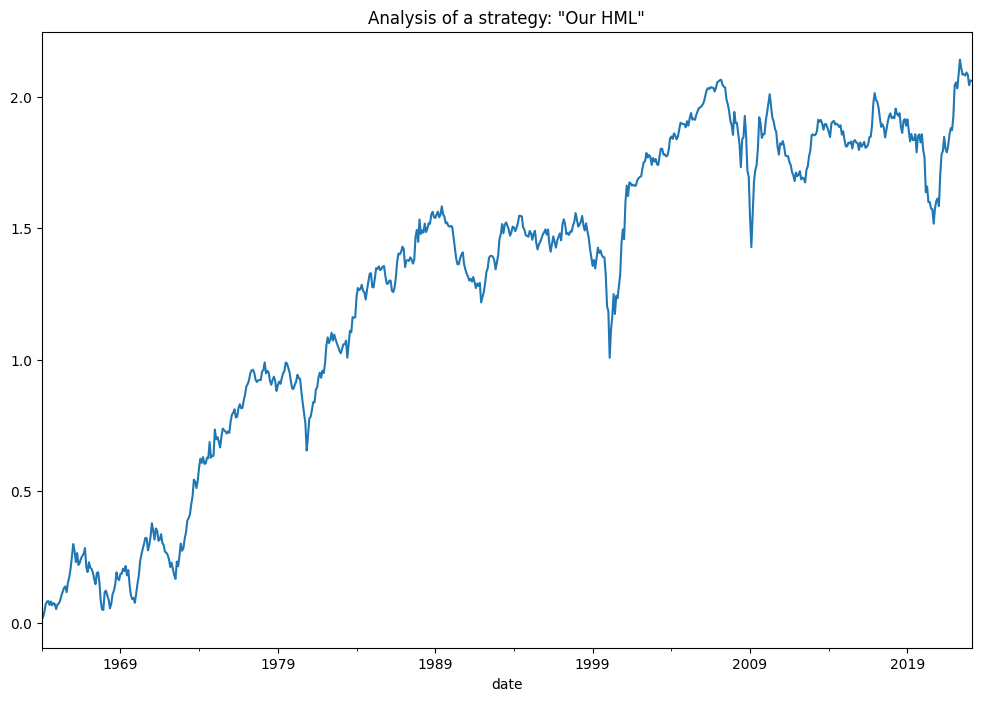

In [10]:
analyze_returns(hml, 'Our HML', end_date='2024-06')

## Read Fama and French data from the pickle file we created previously

In [11]:
ff_data = pd.read_pickle('/home/jovyan/data/ff_data.pkl')
ff_data.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
2024-07-01,0.0124,0.0828,0.0574,0.0022,0.0043,0.0045
2024-08-01,0.0161,-0.0365,-0.0113,0.0085,0.0086,0.0048
2024-09-01,0.0174,-0.0102,-0.0259,0.0004,-0.0026,0.0040
2024-10-01,-0.0097,-0.0088,0.0089,-0.0138,0.0103,0.0039
2024-11-01,0.0650,0.0478,-0.0005,-0.0261,-0.0217,0.0040


In [12]:
merged_data = pd.concat([hml, smb, ff_data], axis=1).dropna()
merged_data[['hml', 'smb', 'Mkt-RF', 'SMB', 'HML']].corr().round(3)

,hml,smb,Mkt-RF,SMB,HML
hml,1.000,-0.200,-0.105,-0.014,0.838
smb,-0.200,1.000,0.273,0.911,-0.183
Mkt-RF,-0.105,0.273,1.000,0.281,-0.211
SMB,-0.014,0.911,0.281,1.000,-0.028
HML,0.838,-0.183,-0.211,-0.028,1.000


<br>
<div style="text-align: center; font-family: 'Georgia', sans-serif; font-size: 36px; font-weight: bold; color: red;">
    Carhart's Momentum Factor (UMD)
</div>

Momentum in stock returns is typically defined by sorting on stocks returns from month t-12 to month t-2 

I construct the equivalent of the Fama and French's UMD (which is Carhart's ```PR1YR```) factor

**Notes**: 

- This factor is rebalanced monthly, and so I set ```annual=False```
- In the earlier code I posted, I didn't do ```groupby(level='permno')``` when computing ```r12_2``` and so, in the cases in which the data switch from one stock to the next, the signal might have been based on wrong returns
  - The ```droplevel(0)``` part of the code on this row might look weird. This method drops the first level of the dataframe's index.
  - The reason it is needed is that ```rolling``` creates a hierarchical index, and so it effectively duplicates the ```permno``` level
  - If want to see this in action, just run this line of code: ```cs_crsp.groupby(level='permno')['ret'].rolling(window=11).count().shift(1)```
  - You'll see from the output that the index no longer matches the index in ```cs_crsp``` and so we need to fix it

In [13]:
cs_crsp = pd.read_pickle('/home/jovyan/data/cs_crsp.pkl')
cs_crsp['asset_growth'] = cs_crsp['at'] / cs_crsp.groupby(level='permno')['at'].shift(12)
cs_crsp

exchcd       ret          me       at     sale     cogs  \
permno date                                                                  
10002  1986-02-01     3.0  0.139785   15.568750      NaN      NaN      NaN   
       1986-03-01     3.0  0.070755   16.670313      NaN      NaN      NaN   
       1986-04-01     3.0  0.052863   17.551562      NaN      NaN      NaN   
       1986-05-01     3.0 -0.020921   17.184375      NaN      NaN      NaN   
       1986-06-01     3.0 -0.132479   14.907813      NaN      NaN      NaN   
...                   ...       ...         ...      ...      ...      ...   
93426  2022-11-01     1.0  0.202074  509.194066  461.889  317.919  171.898   
       2022-12-01     1.0 -0.047326  485.096169  461.889  317.919  171.898   
       2023-01-01     1.0  0.117206  541.952184  461.889  317.919  171.898   
       2023-02-01     1.0  0.009727  547.223581  461.889  317.919  171.898   
       2023-03-01     1.0 -0.042202  524.296779  461.889  317.919  171.898   

                        be  asset_growth  
permno date                               
10002  1986-02-01      NaN           NaN  
       1986-03-01      NaN           NaN  
       1986-04-01      NaN           NaN  
       1986-05-01      NaN           NaN  
       1986-06-01      NaN           NaN  
...                    ...           ...  
93426  2022-11-01  277.099      1.149301  
       2022-12-01  277.099      1.149301  
       2023-01-01  277.099      1.149301  
       2023-02-01  277.099      1.149301  
       2023-03-01  277.099      1.149301  

[816812 rows x 8 columns]

(816812, 11)

(749877, 13)

Start: 1964-01, End: 2023-09
Sharpe ratio: 0.46


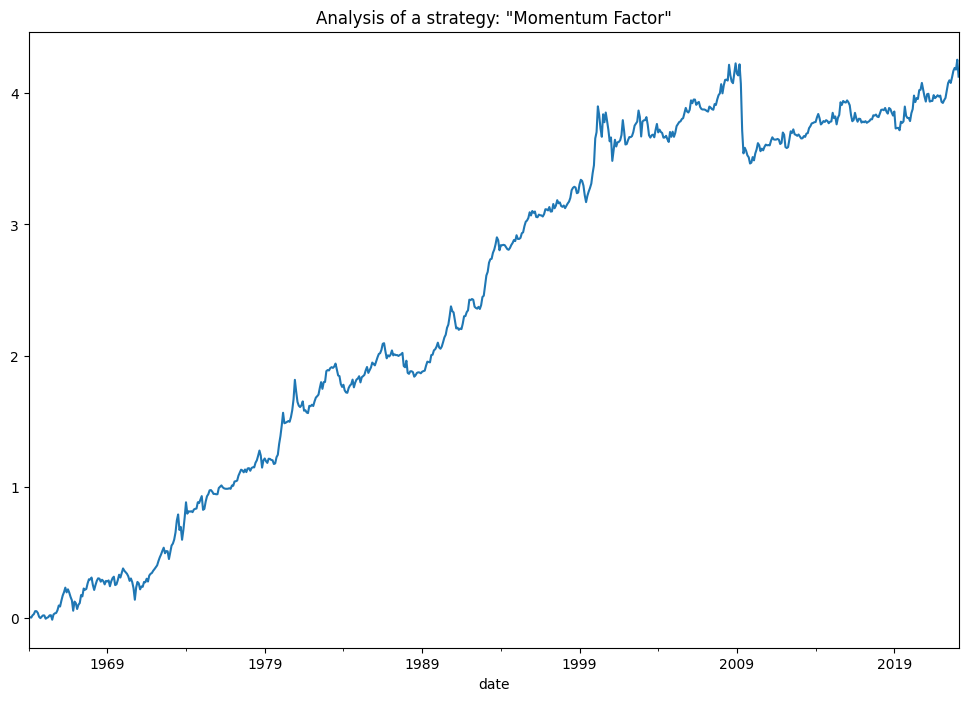

In [14]:
# start from the original data (we will modify it)
cs_crsp = pd.read_pickle('/home/jovyan/data/cs_crsp.pkl')

cs_crsp['r12_2'] = cs_crsp.groupby(level='permno')['ret'].rolling(window=11).sum().shift(1).droplevel(0)
cs_crsp['r12_2_count'] = cs_crsp.groupby(level='permno')['ret'].rolling(window=11).count().shift(1).droplevel(0)

# set to missing if fewer than 6 obs -- newer versions of Pandas could also do ...rolling(window=11).sum(min_count=6)... but the one on JHub seems to be too old
not_ok = cs_crsp['r12_2_count'] < 6
cs_crsp.loc[not_ok, 'r12_2'] = np.nan

sort_variables = ['me', 'r12_2']
percentiles = {'me': [50],
              'r12_2': [30, 70]}

for sortvar in sort_variables:
    cs_crsp = portfolio_sort(df=cs_crsp, col=sortvar, percentiles=percentiles[sortvar], id_col=sortvar + '_group', annual=False)
    
sort_groups = [sortvar + '_group' for sortvar in sort_variables]

portfolio_returns = compute_portfolio_returns(cs_crsp, sort_groups=sort_groups)

umd = portfolio_returns.loc[:,[(1,3), (2,3)]].mean(axis=1) - portfolio_returns.loc[:,[(1,1), (2,1)]].mean(axis=1)
umd = umd.shift(1)
umd.name = 'umd'
analyze_returns(umd, 'Momentum Factor')

<br>
<div style="text-align: center; font-family: 'Georgia', sans-serif; font-size: 36px; font-weight: bold; color: red;">
    Measuring Alphas
</div>

We measure alphas by

```Running a linear regression of strategy returns against some factors```

- In CAPM there is only one factor on the RHS: MKTRF
- In the Fama-French three-factor model, there are three factors: MKTRF, SMB, and HML
- In the Fama-French five-factor model, there are three factors: MKTRF, SMB, HML, RMW, and CMA

**Alphas** measure stocks', managers', or strategies' *abnormal* returns

That is, how profitable an investment is when we 'expunge' from returns any exposures to the factors of the factor model

Notes:

- I use statsmodels.api for running the linear regression
  - This is a well-known (and well-maintained) package
  - The benefit of this package is that it gives a nice, easy summary of the results
- Other packages, such as sklearn, are better for estimating more complex models
  - They don't provide similar summary statistics -- because such summary statistics are often hard to compute for more complicated models

In [15]:
import statsmodels.api as sm

regression_data = pd.concat([umd, ff_data], axis=1).dropna()

y = regression_data['umd']
X = regression_data[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)

# Create a model. This is an OBJECT that comes with methods. We are NOT estimating the model yet, just creating it.
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    umd   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.022
Date:                Thu, 23 Jan 2025   Prob (F-statistic):              0.382
Time:                        19:18:28   Log-Likelihood:                 1214.3
No. Observations:                 712   AIC:                            -2421.
Df Residuals:                     708   BIC:                            -2402.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.002      3.556      0.000       0.003       0.009
Mkt-RF        -0.0096      0.039     -0.246      0.806      -0.086       0.067
SMB           -0.0591      0.057     -1.038      0.300      -0.171       0.053
HML           -0.0765      0.057     -1.347      0.178      -0.188       0.035
==============================================================================
Omnibus:                      193.094   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2162.607
Skew:                          -0.875   Prob(JB):                         0.00
Kurtosis:                      11.357   Cond. No.                         36.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Question:

What if we repeat this computation for our HML factor?

In [16]:
import statsmodels.api as sm

regression_data = pd.concat([hml, ff_data], axis=1).dropna()

y = regression_data['hml']
X = regression_data[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)

# Create a model. This is an OBJECT that comes with methods. We are NOT estimating the model yet, just creating it.
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    hml   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     576.2
Date:                Thu, 23 Jan 2025   Prob (F-statistic):          6.26e-190
Time:                        19:18:29   Log-Likelihood:                 1841.8
No. Observations:                 716   AIC:                            -3676.
Df Residuals:                     712   BIC:                            -3657.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.673      0.501      -0.002       0.001
Mkt-RF         0.0599      0.016      3.646      0.000       0.028       0.092
SMB           -0.0131      0.024     -0.549      0.583      -0.060       0.034
HML            0.9843      0.024     41.244      0.000       0.937       1.031
==============================================================================
Omnibus:                       57.240   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.415
Skew:                           0.209   Prob(JB):                     1.03e-52
Kurtosis:                       5.802   Cond. No.                         36.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""